# D1: REBCO Magnet Mass-Field Trade Space
Can we build an HTS magnet light enough for Starship reentry?

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
from src.magnets import (
    CoilDesigner, run_trade_sweep, pareto_front
)

In [2]:
## Parametric Sweep
df = run_trade_sweep(save_path='../results/trade_space.parquet')
print(f"Total configs: {len(df)}")
print(f"Feasible: {df['feasible'].sum()}")
print(f"Feasible %: {df['feasible'].mean():.0%}")
df[df['feasible']].head(10)

Total configs: 400
Feasible: 400
Feasible %: 100%


,B_target,radius,T_op,N_turns,I_op,m_tape,m_struct,m_cryo,m_total,Ic_margin,feasible,model
0,0.5,0.5,20.0,428,465.60,14.344210,28.688421,10.367256,68.399887,0.8,True,v1
1,0.5,0.5,30.0,500,398.40,16.757255,33.514510,10.367256,75.639021,0.8,True,v1
2,0.5,0.5,40.0,601,331.20,20.142221,40.284442,10.367256,85.793918,0.8,True,v1
3,0.5,0.5,50.0,738,269.76,24.733709,49.467417,10.367256,99.568382,0.8,True,v1
4,0.5,0.5,65.0,1121,177.60,37.569766,75.139532,10.367256,138.076554,0.8,True,v1
5,0.5,1.0,20.0,428,465.60,28.688421,57.376842,19.792034,120.857296,0.8,True,v1
6,0.5,1.0,30.0,500,398.40,33.514510,67.029021,19.792034,135.335565,0.8,True,v1
7,0.5,1.0,40.0,601,331.20,40.284442,80.568883,19.792034,155.645358,0.8,True,v1
8,0.5,1.0,50.0,738,269.76,49.467417,98.934835,19.792034,183.194286,0.8,True,v1
9,0.5,1.0,65.0,1121,177.60,75.139532,150.279065,19.792034,260.210631,0.8,True,v1


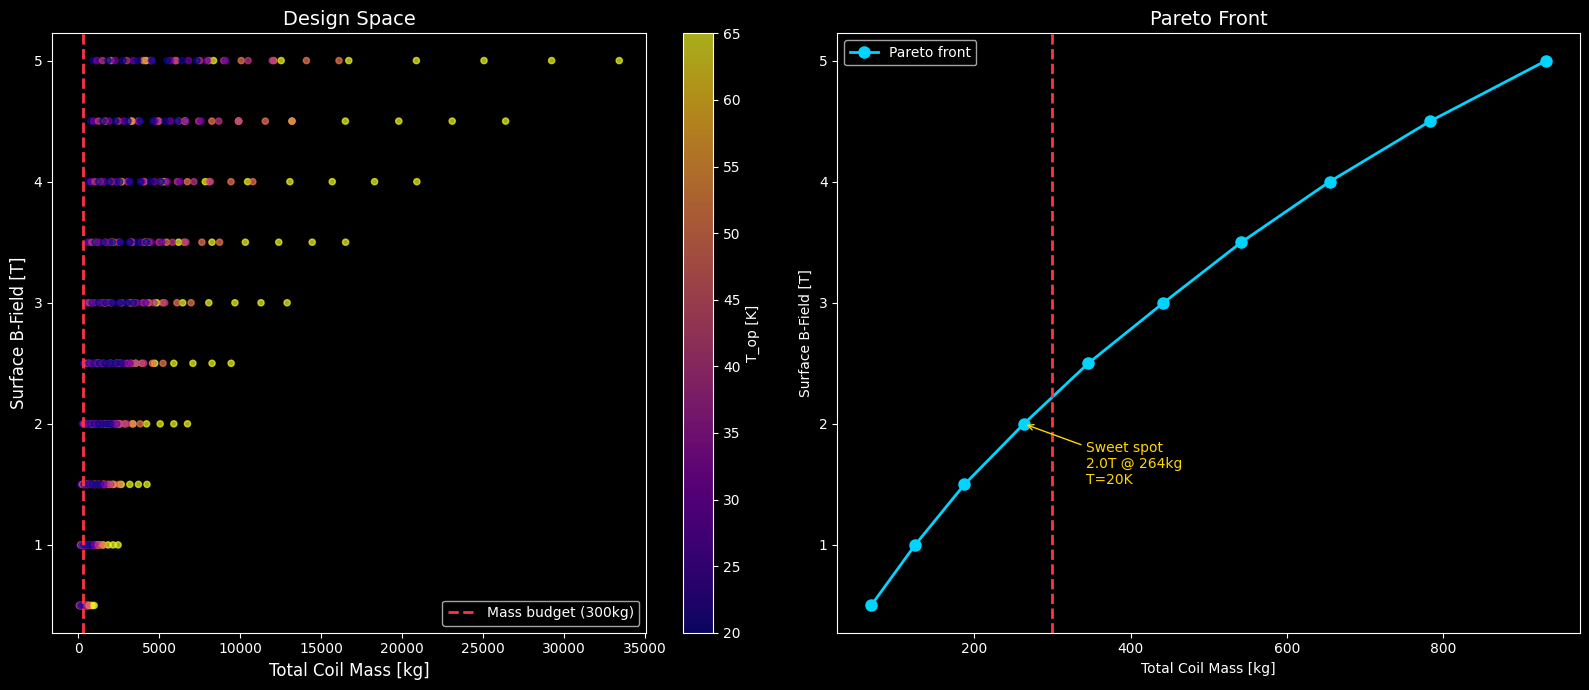

In [3]:
## Trade Space Visualization
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

feas = df[df['feasible']].copy()
mass_budget = 300

ax = axes[0]
sc = ax.scatter(feas['m_total'], feas['B_target'],
                c=feas['T_op'], cmap='plasma', s=20, alpha=0.7)
ax.axvline(mass_budget, color='#FF3344', ls='--', lw=2,
           label=f'Mass budget ({mass_budget}kg)')
ax.set_xlabel('Total Coil Mass [kg]', fontsize=12)
ax.set_ylabel('Surface B-Field [T]', fontsize=12)
ax.set_title('Design Space', fontsize=14)
ax.legend(fontsize=10)
plt.colorbar(sc, ax=ax, label='T_op [K]')

ax2 = axes[1]
pf = pareto_front(feas)
ax2.plot(pf['m_total'], pf['B_target'], 'o-',
         color='#00D4FF', lw=2, markersize=8, label='Pareto front')
ax2.axvline(mass_budget, color='#FF3344', ls='--', lw=2)

under_budget = pf[pf['m_total'] <= mass_budget]
if len(under_budget) > 0:
    best = under_budget.iloc[-1]
    ax2.annotate(
        f"Sweet spot\n{best['B_target']:.1f}T @ {best['m_total']:.0f}kg\nT={best['T_op']:.0f}K",
        xy=(best['m_total'], best['B_target']),
        fontsize=10, color='#FFD700',
        arrowprops=dict(arrowstyle='->', color='#FFD700'),
        xytext=(best['m_total']+80, best['B_target']-0.5)
    )

ax2.set_xlabel('Total Coil Mass [kg]')
ax2.set_ylabel('Surface B-Field [T]')
ax2.set_title('Pareto Front', fontsize=14)
ax2.legend()

plt.tight_layout()
fig.savefig('../results/figures/d1_trade.png', dpi=300, bbox_inches='tight')
fig.savefig('../results/figures/d1_trade.pdf', bbox_inches='tight')
plt.show()

In [4]:
## Key Result
pf = pareto_front(df[df['feasible']])
under = pf[pf['m_total'] <= 300]
if len(under) > 0:
    best = under.iloc[-1]
    print(f"KEY RESULT: Maximum B under 300kg budget = "
          f"{best['B_target']:.1f} T at T_op = {best['T_op']:.0f} K, "
          f"R = {best['radius']:.1f} m, mass = {best['m_total']:.0f} kg")
else:
    print("WARNING: No feasible config under 300 kg")

KEY RESULT: Maximum B under 300kg budget = 2.0 T at T_op = 20 K, R = 0.5 m, mass = 264 kg


---
## v11 Physics Correction: Finite Solenoid

The v1 model above uses `B = μ₀nI` (infinite solenoid). For the paper geometry (R=0.5m, L=0.6m), the **Fabry factor** F = L/√(L²+4R²) = 0.514 means the infinite formula overestimates the center field by ~2×. The v11 model corrects for this, also using K_struct=1.0 (not 2.0) and adding 105 kg of flight auxiliaries.

**Impact:** More turns needed → more tape → heavier coil. The 264 kg v1 estimate becomes ~400–500 kg in v11.

In [5]:
## v11 Mass-Field Trade Table (D5.6)
from src.physics_v11 import fabry_factor, compute_B2dA, stuart_number, post_shock_velocity

cd = CoilDesigner()
B_values = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0]

print("v11 MASS-FIELD TRADE TABLE")
print(f"Geometry: R=0.5m, L=0.6m, T_op=20K")
print(f"Fabry factor F = {fabry_factor(0.5, 0.6):.3f}")
print("=" * 75)
print(f"{'B[T]':>5} {'N_turns':>8} {'m_tape':>8} {'m_coil':>8} {'m_flight':>10} {'B²dA':>8} {'S(LEO)':>8}")
print("-" * 75)

v11_data = []
for B in B_values:
    d = cd.design_solenoid_v11(B, radius=0.5, T_op=20, length=0.6)
    if d is None:
        print(f"{B:5.1f}   INFEASIBLE")
        continue
    B2dA = compute_B2dA(B, 0.5)
    v_ps = post_shock_velocity(7800)
    # Stuart number at ~60km LEO: σ≈50 S/m, ρ_ps≈5×3e-5
    S = stuart_number(50, B, v_ps, 0.6, 5 * 3e-5)
    print(f"{B:5.1f} {d['N_turns']:8d} {d['m_tape']:8.0f} {d['m_coil']:8.0f} "
          f"{d['m_flight']:10.0f} {B2dA:8.2f} {S:8.0f}")
    v11_data.append({'B': B, 'm_coil': d['m_coil'], 'm_flight': d['m_flight'],
                     'N_turns': d['N_turns'], 'B2dA': B2dA, 'S_LEO': S})

print("\nNotes:")
print("  m_coil  = tape + structure (1:1) + cryostat + cryocooler")
print("  m_flight = m_coil + 85 kg electronics + 20 kg harness")
print(f"  Paper v11 at 2T: m_coil ≈ 498 kg, m_flight ≈ 782 kg")

v11 MASS-FIELD TRADE TABLE
Geometry: R=0.5m, L=0.6m, T_op=20K
Fabry factor F = 0.514
 B[T]  N_turns   m_tape   m_coil   m_flight     B²dA   S(LEO)
---------------------------------------------------------------------------
  0.5      997       33       94        199     0.10       32
  1.0     2302       77      181        286     0.39      128
  1.5     3767      126      280        385     0.88      288
  2.0     5524      185      397        502     1.57      513
  3.0     9667      324      675        780     3.53     1154
  4.0    14592      489     1005       1110     6.28     2051

Notes:
  m_coil  = tape + structure (1:1) + cryostat + cryocooler
  m_flight = m_coil + 85 kg electronics + 20 kg harness
  Paper v11 at 2T: m_coil ≈ 498 kg, m_flight ≈ 782 kg


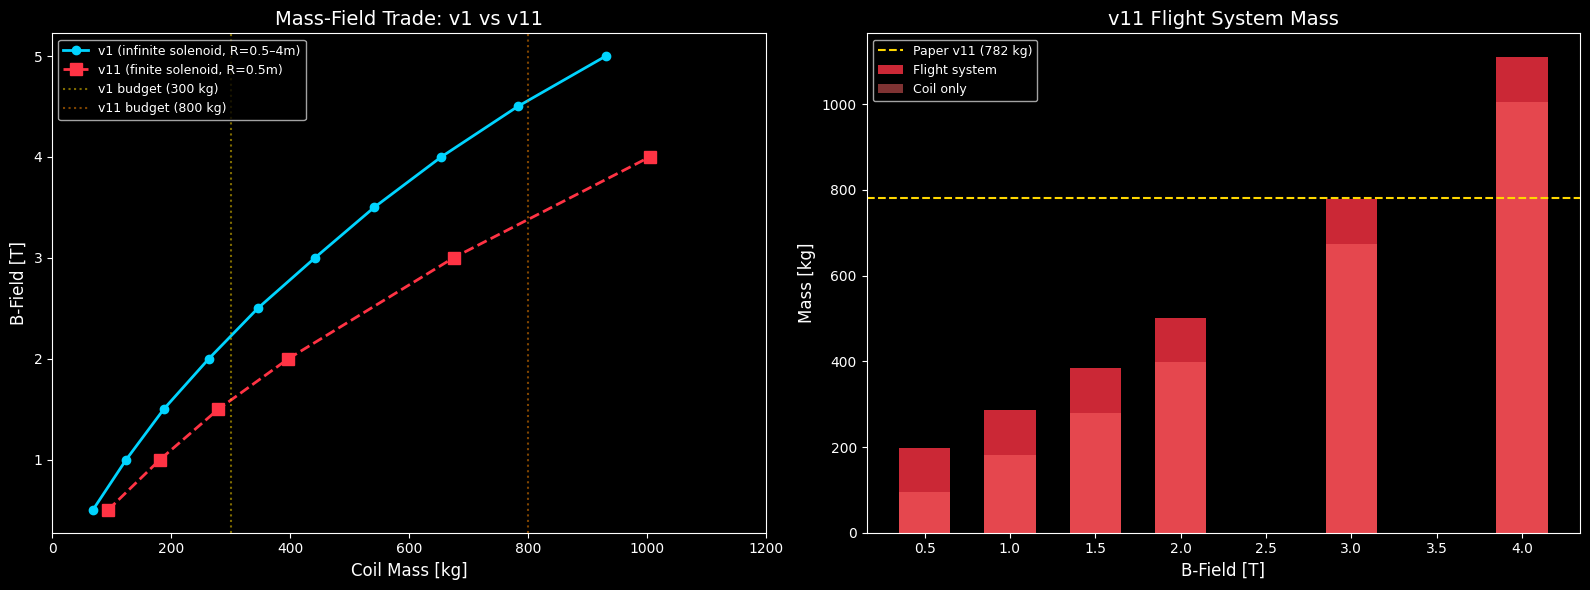

Saved: d1_v11_comparison.png/pdf


In [6]:
## v1 vs v11 Mass Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Pareto fronts
ax = axes[0]
pf = pareto_front(df[df['feasible']])
ax.plot(pf['m_total'], pf['B_target'], 'o-',
        color='#00D4FF', lw=2, markersize=6,
        label='v1 (infinite solenoid, R=0.5–4m)')

m_v11 = [d['m_coil'] for d in v11_data]
B_v11 = [d['B'] for d in v11_data]
ax.plot(m_v11, B_v11, 's--',
        color='#FF3344', lw=2, markersize=8,
        label='v11 (finite solenoid, R=0.5m)')

ax.axvline(300, color='#FFD700', ls=':', alpha=0.5, label='v1 budget (300 kg)')
ax.axvline(800, color='#FF8800', ls=':', alpha=0.5, label='v11 budget (800 kg)')
ax.set_xlabel('Coil Mass [kg]', fontsize=12)
ax.set_ylabel('B-Field [T]', fontsize=12)
ax.set_title('Mass-Field Trade: v1 vs v11', fontsize=14)
ax.legend(fontsize=9)
ax.set_xlim(0, 1200)

# Right: Flight system mass
ax2 = axes[1]
m_flight = [d['m_flight'] for d in v11_data]
ax2.bar(B_v11, m_flight, width=0.3, color='#FF3344', alpha=0.8, label='Flight system')
ax2.bar(B_v11, m_v11, width=0.3, color='#FF6666', alpha=0.5, label='Coil only')
ax2.axhline(782, color='#FFD700', ls='--', lw=1.5, label='Paper v11 (782 kg)')
ax2.set_xlabel('B-Field [T]', fontsize=12)
ax2.set_ylabel('Mass [kg]', fontsize=12)
ax2.set_title('v11 Flight System Mass', fontsize=14)
ax2.legend(fontsize=9)

plt.tight_layout()
fig.savefig('../results/figures/d1_v11_comparison.png', dpi=300, bbox_inches='tight')
fig.savefig('../results/figures/d1_v11_comparison.pdf', bbox_inches='tight')
plt.show()
print("Saved: d1_v11_comparison.png/pdf")